# TRF encoding results: 4 models

In [2]:
# return figures in svg
%config InlineBackend.figure_formats = ['svg']
    
import numpy as np
import pandas as pd
from scipy import stats
from mne.stats import fdr_correction
from string import ascii_letters as abc

from itertools import product
from os.path import join as pjoin

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm
from matplotlib_venn import venn2
from mpl_toolkits.axes_grid.inset_locator import inset_axes

import warnings 
warnings.simplefilter('ignore')

from playing.misc_functions import jn, get_subjects, sujs_selection, flatten
from playing.elecs_handling import split_hemis, correct_chnames
from playing.collect_df import ispeech_df
from playing.h5_funcs import h5Funcs

from plotters.plot_decorators import cmap_custom, draw_cmap, my_fonts, set_cmapnorm

from params.get_rigid import getRigid
rigid = getRigid()

%matplotlib inline

sujs = get_subjects()
print(sujs)

2022-10-16 10:10:12,447 [91226] INFO     numexpr.utils: NumExpr defaulting to 8 threads.
2022-10-16 10:10:13,367 [91226] WARNING  py.warnings: /var/folders/fj/_w5hzt0j4x5g80tyrsrzm65c0000gq/T/ipykernel_91226/3481692480.py:17: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes



['sub-9d783b836f5e', 'sub-14c725b6b803', 'sub-28e70e7c7fbb', 'sub-83ebd5328120', 'sub-cacae171ee15', 'sub-95a634be7e05', 'sub-26176ef8a8d0', 'sub-44375d501493', 'sub-a4e7fc9daa96', 'sub-c1b7ce54ce05', 'sub-3ef8645f99c5', 'sub-fccb4adbfadc', 'sub-ebf231d97f73', 'sub-e0bb6ccef2a5', 'sub-4247d6d6cdbf', 'sub-45a6830d263e', 'sub-82e330f8aadd', 'sub-c2a96116ddc4']


---
---
**TRF Models** correspond to:
1. Envelope & low (i.e. 1-9Hz)
1. Envelope & HFa (i.e. 80-120Hz)
1. PeakRate & low (i.e. 1-9Hz)
1. PeakRate & HFa (i.e. 80-120Hz)

**Fixed variables** 

In [3]:
analysis = 'TRF'
alpha = .01
d = {}

*Lists*

In [4]:
models = ['model1', 'model2', 'model3', 'model4']
sounds = ['speech', 'music']
hemis = ['left', 'right']

*Plotting colors and cmaps*

In [5]:
my_cmap = {}
color = rigid.plot_colors()
my_cmap['main'] = cmap_custom('gradient')
for sound in sounds:
    my_cmap[jn(['main', sound])] = cmap_custom(
        'gradient', top_color=color[sound][1])
color

{'speech': [array([[242, 152, 154]]),
  array([[254,  75,  73]]),
  array([[219, 129, 130]]),
  array([[193, 103, 104]]),
  array([[182,  92,  93]])],
 'music': [array([[148, 210, 221]]),
  array([[ 43, 183, 200]]),
  array([[114, 183, 194]]),
  array([[ 88, 157, 167]]),
  array([[ 77, 146, 156]])],
 'shared': [array([[243, 222, 168]]),
  array([[255, 214, 102]]),
  array([[220, 199, 145]]),
  array([[194, 173, 118]]),
  array([[183, 162, 107]])],
 'shared_green': [array([[145, 206, 180]]),
  array([[ 99, 185, 149]]),
  array([[ 69, 129, 104]])],
 'neither': [array([[210, 184, 217]]),
  array([[191, 154, 202]]),
  array([[133, 107, 141]]),
  array([[93, 74, 98]])],
 'neither_grey': [array([[230, 229, 234]]),
  array([[184, 183, 187]]),
  array([[132, 131, 134]]),
  array([[110, 109, 112]])]}

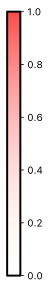

In [6]:
which = my_cmap['main_music']
which, norm = set_cmapnorm(['main'], 0.1, .3, 'speech', alpha=True)
draw_cmap(which);

## Prepare DataFrame

### **Collect base data** from presaved DF

In [7]:
df = ispeech_df(analyses=['trf'])

In [8]:
hemi = 'left'
all_seeds = []
for i, subject in enumerate(sujs):
    if subject not in sujs_selection(sujs, 'implantation', hemi):
        continue
    h5_sub = h5Funcs('connectivity', subject)
    seed_name = h5_sub.h5_read(
        keys=('connectivity_seed', 'seed_name_' + hemi, )).astype('U13')
    all_seeds.append(jn([str(seed_name), abc[i]]))

df.loc[df['chnames'].isin(all_seeds)]

subject     chnames  \
118   sub-9d783b836f5e   H'6-H'7_a   
213   sub-14c725b6b803   H'7-H'8_b   
405   sub-28e70e7c7fbb  H'9-H'10_c   
438   sub-83ebd5328120   H'5-H'6_d   
620   sub-cacae171ee15  H'9-H'10_e   
734   sub-95a634be7e05   H'8-H'9_f   
866   sub-26176ef8a8d0   H'8-H'9_g   
984   sub-44375d501493   H'6-H'7_h   
1250  sub-c1b7ce54ce05   H'6-H'7_j   
1384  sub-3ef8645f99c5   H'8-H'9_k   
1544  sub-fccb4adbfadc   H'8-H'9_l   
1689  sub-ebf231d97f73   H'7-H'8_m   
1767  sub-e0bb6ccef2a5   H'7-H'8_n   
1873  sub-4247d6d6cdbf   H'6-H'7_o   
2262  sub-c2a96116ddc4   H'7-H'8_r   

                                            brainnetome      left_x  \
118     INS, Left Insular Gyrus G, hypergranular insula  450.120687   
213     INS, Left Insular Gyrus G, hypergranular insula  442.467328   
405   STG, Left Superior Temporal Gyrus A41/42, area...  455.438917   
438         Tha, Left Thalamus Otha, occipital thalamus  456.423811   
620   STG, Left Superior Temporal Gyrus A22r, rostra...  425.174362   
734                                      no_label_found  468.720073   
866   STG, Left Superior Temporal Gyrus A22r, rostra...  435.641921   
984                                      no_label_found  467.824153   
1250                                     no_label_found  454.670642   
1384  STG, Left Superior Temporal Gyrus A41/42, area...  447.318857   
1544  STG, Left Superior Temporal Gyrus A41/42, area...  423.247492   
1689  STG, Left Superior Temporal Gyrus A41/42, area...  457.694374   
1767    INS, Left Insular Gyrus G, hypergranular insula  437.948239   
1873                                     no_label_found  468.218790   
2262  STG, Left Superior Temporal Gyrus TE1.0 and TE1.2  444.256259   

          left_y     right_x     right_y       top_x       top_y     front_x  \
118   420.078023  360.157634  411.449022  242.973703  421.251681  556.257543   
213   433.364120  366.148863  422.131300  246.091554  414.405414  555.124164   
405   406.408599  357.530295  399.762778  216.341817  425.269534  580.705948   
438   453.815162  351.383816  443.324263  300.110738  427.754648  501.114879   
620   441.414196  380.698611  426.620181  220.711733  399.029625  583.442097   
734   422.458134  345.223584  413.437350  245.051731  437.303172  552.682222   
866   439.475670  372.684986  425.113308  220.212306  407.800905  582.583310   
984   414.320667  344.896036  407.508849  257.317343  437.434072  539.944081   
1250  403.168477  354.660327  398.872821  270.475411  426.780771  527.151948   
1384  413.747717  362.185835  406.567260  245.967870  419.110495  552.942240   
1544  416.683554  381.990499  407.967598  225.082963  397.821466  576.564288   
1689  407.647921  353.588329  401.849978  249.923110  428.495418  547.510166   
1767  416.939867  369.739260  409.051485  244.806203  410.866319  555.288335   
1873  401.233403  344.060297  397.051491  262.522634  438.573123  533.691953   
2262  414.703624  364.645186  407.321272  245.828313  416.420058  553.458451   

      ...  trf_music_model1_p  \
118   ...        0.000000e+00   
213   ...        1.029037e-88   
405   ...        4.001048e-10   
438   ...        3.712437e-05   
620   ...        4.174045e-34   
734   ...       3.065980e-315   
866   ...        1.400214e-16   
984   ...       9.079107e-130   
1250  ...        0.000000e+00   
1384  ...       9.640153e-240   
1544  ...        2.312488e-37   
1689  ...        1.506986e-46   
1767  ...        2.528159e-60   
1873  ...        0.000000e+00   
2262  ...        0.000000e+00   

                      trf_music_model2_cross-validation trf_music_model2_r  \
118   [0.046670498958858844, 0.054720804070117125, 0...           0.079987   
213   [-0.037403048416853935, -0.010577558054194044,...           0.077760   
405   [0.025488192433973534, 0.04332336850486267, 0....           0.006022   
438   [-0.041717939653865825, -0.0387036491427335, -...          -0.014233   
620   [-0.0379386939028147, 0.06561275762891296, 0.0...           0.0

### Add statistics (**main effects**)

#### Old method with ttest

In [9]:
for model, sound in product(models, sounds):
    # get data
    data = np.array(
        [x for x in df['trf_%s_%s_cross-validation' % (sound, model)].values])
    tstat, pval = stats.ttest_1samp(data, 0, axis=1, nan_policy='omit')

    # correct for multiple comparison
    mask = np.isfinite(pval)
    _, pval[mask] = fdr_correction(pval[mask])

    # all sign indexes
    indexes = [x[0] for x in np.argwhere(pval < (alpha * 2))]
    sign_df = df.iloc[indexes]
    sign_df[jn(['trf_main_%s_%s' % (model, sound), 'sign'])] = [
        x for x in tstat[indexes]]
    df = df.join(
        sign_df[jn(['trf_main_%s_%s' % (model, sound), 'sign'])]).fillna(df)

#### New method from function, just using the p-value (FDR corrected) from the pearson correlation

In [10]:
for model, sound in product(models, sounds):
    # get significant positive correlations
    h_index = df.index[(df['trf_%s_%s_r' % (sound, model)] > 0) & (df['trf_%s_%s_p' % (sound, model)] < .01)]
    h_df = df.loc[h_index]
    
    # merge with old df
    h_df[jn(['trf_main_%s_%s' % (model, sound), 'new_sign'])] =  [x for x in h_df['trf_%s_%s_r' % (sound, model)].values]
    df = df.join(h_df[jn(['trf_main_%s_%s' % (model, sound), 'new_sign'])]).fillna(df)


In [11]:
df_seeds = df.loc[df['chnames'].isin(all_seeds)]
for sound, model in product(sounds, models):
    print(sound, model)
    for i in range(len(df_seeds)):
        values = (df_seeds['trf_main_%s_%s_sign' % (model, sound)].values[i], df_seeds['trf_main_%s_%s_new_sign' % (model, sound)].values[i])
        if not all(i >= 0 for i in values):
            print(df_seeds['subject'].values[i], 'old', df_seeds['trf_main_%s_%s_sign' % (model, sound)].values[i], 'new', df_seeds['trf_main_%s_%s_new_sign' % (model, sound)].values[i])

speech model1
sub-83ebd5328120 old nan new 0.07187819298062703
speech model2
sub-83ebd5328120 old nan new nan
speech model3
sub-28e70e7c7fbb old nan new nan
sub-83ebd5328120 old nan new 0.037522409688356795
speech model4
sub-28e70e7c7fbb old nan new 0.10070802421750932
sub-83ebd5328120 old nan new nan
sub-26176ef8a8d0 old nan new 0.08057148043282292
music model1
sub-28e70e7c7fbb old nan new 0.06505926070448392
sub-83ebd5328120 old nan new 0.04567677955624196
sub-26176ef8a8d0 old nan new 0.08281874326113317
music model2
sub-14c725b6b803 old nan new 0.0777599876251583
sub-28e70e7c7fbb old nan new nan
sub-83ebd5328120 old nan new nan
sub-cacae171ee15 old nan new 0.047130743555672656
sub-26176ef8a8d0 old nan new 0.06622554715441098
music model3
sub-28e70e7c7fbb old nan new 0.06375638841687731
sub-83ebd5328120 old nan new 0.04992958404576692
sub-26176ef8a8d0 old nan new 0.058414893539991235
music model4
sub-14c725b6b803 old nan new nan
sub-28e70e7c7fbb old 4.941775915765268 new nan
sub-83eb

In [12]:
# how many electrodes were significant in the crossvalidation and are no longer significant in the actual predict
for model, sound in product(models, sounds):
    prev = len(df.loc[(df['trf_main_%s_%s_sign' % (model, sound)] > 0)])
    t_df = df.loc[(df['trf_main_%s_%s_sign' % (model, sound)] > 0) & ~(df['trf_main_%s_%s_new_sign' % (model, sound)] > 0)]
    print('for %s from %s channels, we lose %s channels, ie %s%%' % (jn([model, sound]), prev, len(t_df), round(len(t_df) / prev * 100)))

for model1_speech from 482 channels, we lose 52 channels, ie 11%
for model1_music from 231 channels, we lose 40 channels, ie 17%
for model2_speech from 215 channels, we lose 28 channels, ie 13%
for model2_music from 107 channels, we lose 12 channels, ie 11%
for model3_speech from 422 channels, we lose 34 channels, ie 8%
for model3_music from 208 channels, we lose 31 channels, ie 15%
for model4_speech from 163 channels, we lose 21 channels, ie 13%
for model4_music from 92 channels, we lose 11 channels, ie 12%


## Find shared versus selective indices

### Shared and unique significant electrodes between sounds for each models contrast

### When statistics are on cross-validation

In [13]:
trf = {}
for model in ['model1', 'model2', 'model3', 'model4']:
    trf[model + '_shared_i'] = df.loc[(df['trf_main_%s_speech_sign' % model] > 0) & (
        df['trf_main_%s_music_sign' % model] > 0)]
    trf[model + '_speech_i'] = df.loc[(df['trf_main_%s_speech_sign' %
                                       model] > 0) & ~(df['trf_main_%s_music_sign' % model] > 0)]
    trf[model + '_music_i'] = df.loc[~(df['trf_main_%s_speech_sign' % model] > 0) & (
        df['trf_main_%s_music_sign' % model] > 0)]
    print(model, 'shared', len(trf[model + '_shared_i']), 'speech', len(
        trf[model + '_speech_i']), 'music', len(trf[model + '_music_i']))

model1 shared 194 speech 288 music 37
model2 shared 91 speech 124 music 16
model3 shared 169 speech 253 music 39
model4 shared 75 speech 88 music 17


### When statistics are on ML prediction

In [14]:
trf = {}
for model in ['model1', 'model2', 'model3', 'model4']:
    trf[model + '_shared_i'] = df.loc[(df['trf_main_%s_speech_new_sign' % model] > 0) & (
        df['trf_main_%s_music_new_sign' % model] > 0)]
    trf[model + '_speech_i'] = df.loc[(df['trf_main_%s_speech_new_sign' %
                                       model] > 0) & ~(df['trf_main_%s_music_new_sign' % model] > 0)]
    trf[model + '_music_i'] = df.loc[~(df['trf_main_%s_speech_new_sign' % model] > 0) & (
        df['trf_main_%s_music_new_sign' % model] > 0)]
    print(model, 'shared', len(trf[model + '_shared_i']), 'speech', len(
        trf[model + '_speech_i']), 'music', len(trf[model + '_music_i']))

model1 shared 298 speech 568 music 203
model2 shared 146 speech 269 music 121
model3 shared 336 speech 606 music 179
model4 shared 115 speech 157 music 97


## Start the plotting

### TRF **model comparison**

Comparing model 1 directly to the other models:
1. **Shared:** How many electrodes are significant between both models (i.e. model 1 and the model it is compared to) 
1. **Model 1:** How many electrodes are significant in model 1 and not represented in the other model
1. **Other model:** How many electrodes are significant in the other model and not represented in model 1


In [15]:
main_model = 'model3'
other_models = [x for x in models if x != main_model]
for model, sound in product(other_models, sounds):
    trf[jn([sound, model, 'shared_i'])] = df.loc[(df['trf_main_%s_%s_new_sign' % (
        main_model, sound)] > 0) & (df['trf_main_%s_%s_new_sign' % (model, sound)] > 0)]
    trf[jn([sound, model, main_model, 'i'])] = df.loc[(df['trf_main_%s_%s_new_sign' % (
        main_model, sound)] > 0) & ~(df['trf_main_%s_%s_new_sign' % (model, sound)] > 0)]
    trf[jn([sound, model, 'other_model_i'])] = df.loc[~(df['trf_main_%s_%s_new_sign' % (
        main_model, sound)] > 0) & (df['trf_main_%s_%s_new_sign' % (model, sound)] > 0)]
    print(sound, 'shared', len(trf[jn([sound, model, 'shared_i'])]), main_model, len(trf[jn(
        [sound, model, main_model, 'i'])]), model, len(trf[jn([sound, model, 'other_model_i'])]))

speech shared 636 model3 306 model1 230
music shared 294 model3 221 model1 207
speech shared 265 model3 677 model2 150
music shared 128 model3 387 model2 139
speech shared 213 model3 729 model4 59
music shared 106 model3 409 model4 106


for music_model4 the total number of sign channels is 11 which comes down to 0% of the data


Text(50, -190, 'Channels significant\nin both models ')

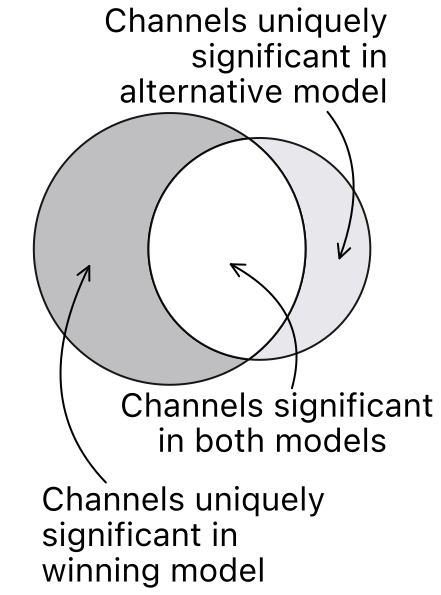

In [16]:
plt.figure(figsize=([7, 7]))
n0 = 0
new_list = [main_model, 'other_model', 'shared']
circles = ('10', '01', '11')

tmp = [5, 2, 4]

print('for %s the total number of sign channels is %s which comes down to %s%% of the data' % (jn([sound, model]), sum(np.array(tmp)), round(sum(np.array(tmp)) / len(df) * 100)))

tmp = np.round(tmp / np.sum(tmp) * 100, 0).astype(int)
c = venn2(tmp, set_labels=None, alpha=.9)
c.get_patch_by_id('10').set_color(color['neither_grey'][1] / 255)
c.get_patch_by_id('11').set_color('white')
c.get_patch_by_id('01').set_color(color['neither_grey'][0] / 255)
c.get_patch_by_id('11').set_edgecolor('black')
c.get_patch_by_id('10').set_edgecolor('black')
c.get_patch_by_id('01').set_edgecolor('black')
# c.get_patch_by_id('11').set_linewidth(13)
for circle in circles:
    c.get_label_by_id(circle).set_text('')
plt.annotate('%s' % ('Channels uniquely\nsignificant in\nwinning model '),
             xy=c.get_label_by_id('10').get_position() -
             np.array([0, 0.05]),
             xytext=(-50, -320),
             ha='left',
             fontsize=33,
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->',
                             connectionstyle='arc3, rad=-0.5',
                             color='black'))

plt.annotate('%s' % ('Channels uniquely\nsignificant in\nalternative model'),
             xy=c.get_label_by_id('01').get_position() -
             np.array([0, 0.05]),
             xytext=(50, 160),
             ha='right',
             fontsize=33,
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->',
                             connectionstyle='arc3, rad=-0.5',
                             color='black'))

plt.annotate('%s' % ('Channels significant\nin both models '),
             xy=c.get_label_by_id('11').get_position() -
             np.array([0, 0.05]),
             xytext=(50, -190),
             ha='center',
             fontsize=33,
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->',
                             connectionstyle='arc3, rad=0.5',
                             color='black'))

for speech_model1 the total number of sign channels is 1172 which comes down to 51% of the data
for speech_model2 the total number of sign channels is 1092 which comes down to 47% of the data
for speech_model4 the total number of sign channels is 1001 which comes down to 43% of the data
for music_model1 the total number of sign channels is 722 which comes down to 31% of the data
for music_model2 the total number of sign channels is 654 which comes down to 28% of the data
for music_model4 the total number of sign channels is 621 which comes down to 27% of the data


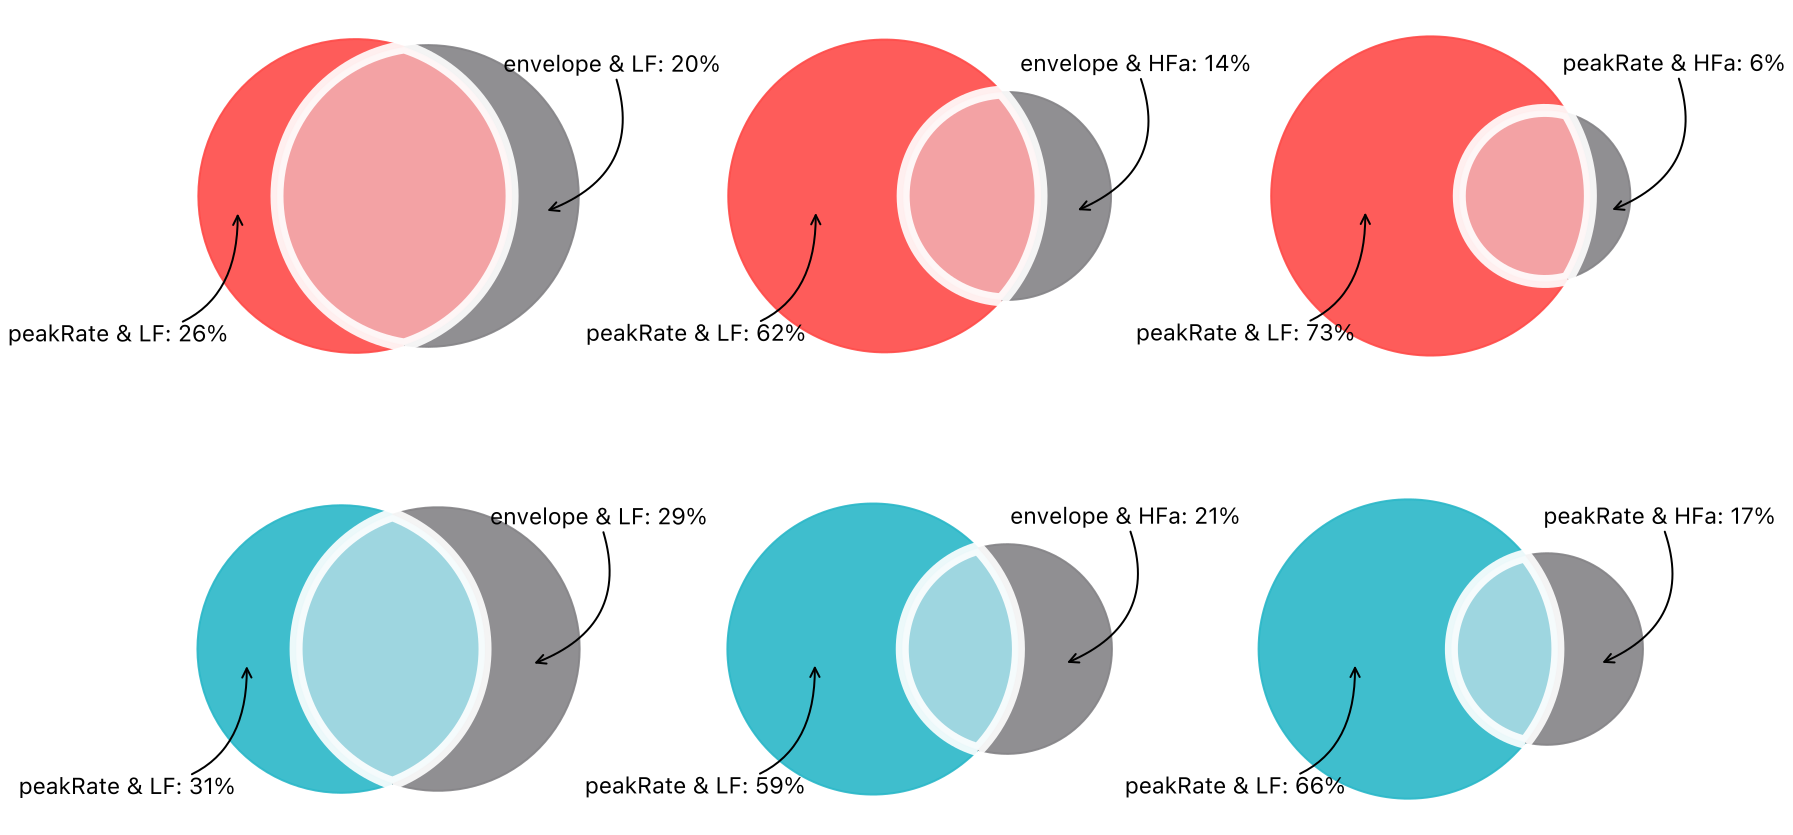

In [17]:
plt.figure(figsize=([27, 15]))
n0 = 0
new_list = [main_model, 'other_model', 'shared']
circles = ('10', '01', '11')
for sound, model in product(sounds, other_models):
    if model == 'model1':
        name = 'envelope & LF'
    elif model == 'model2':
        name = 'envelope & HFa'
    elif model == 'model3':
        name = 'peakRate & LF'
    else:
        name = 'peakRate & HFa'
    n0 += 1
    plt.subplot(2, 3, n0)
    tmp = [len(trf[jn([sound, model, x, 'i'])]) for x in new_list]
    
    print('for %s the total number of sign channels is %s which comes down to %s%% of the data' % (jn([sound, model]), sum(np.array(tmp)), round(sum(np.array(tmp)) / len(df) * 100)))
    
    tmp = np.round(tmp / np.sum(tmp) * 100, 0).astype(int)
    c = venn2(tmp, set_labels=None, alpha=.9)
    c.get_patch_by_id('10').set_color(color[sound][1] / 255)
    c.get_patch_by_id('01').set_color(color['neither_grey'][2] / 255)
    c.get_patch_by_id('11').set_color(color[sound][0] / 255)
    c.get_patch_by_id('11').set_edgecolor('white')
    c.get_patch_by_id('11').set_linewidth(13)
    for circle in circles:
        c.get_label_by_id(circle).set_text('')
    plt.annotate('%s: %s%%' % ('peakRate & LF', tmp[0]),
                 xy=c.get_label_by_id('10').get_position() -
                 np.array([0, 0.05]),
                 xytext=(-120, -130),
                 ha='center',
                 fontsize=23,
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle='->',
                                 connectionstyle='arc3, rad=0.5',
                                 color='black'))
    plt.annotate('%s: %s%%' % (name, tmp[1]),
                 xy=c.get_label_by_id('01').get_position() -
                 np.array([0, 0.05]),
                 xytext=(175, 140),
                 ha='right',
                 fontsize=23,
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle='->',
                                 connectionstyle='arc3, rad=-0.5',
                                 color='black'))

### TRF seed MNI

#### Prepare DF with only two columns *(condition & data)* for **RainCloudplots**

### TRF **r-values**

#### TRF **r-values** seeds of models

In [18]:
model = 'model3'

# prepare lists for only seeds
temp_df = df.loc[df['chnames'].isin(all_seeds)]
labels_l = []
data_l = []
for i, sound in enumerate(sounds):
    data = temp_df['trf_%s_%s_r' % (sound, model)].values
    data = np.array([x for x in data])
    # av_data = np.mean(data, 1)
    labels_l.append([sound] * len(data))
    data_l.append([x for x in data])

# put lists in new DF
n_d = {'labels': flatten(labels_l), 'data': flatten(data_l)}
n_df = pd.DataFrame(n_d)

#### TRF **r-values** best channels for each patient for each sound

In [19]:
t_df.columns

Index(['subject', 'chnames', 'brainnetome', 'left_x', 'left_y', 'right_x',
       'right_y', 'top_x', 'top_y', 'front_x', 'front_y',
       'left_seed_and_twins', 'trf_speech_model1_cross-validation',
       'trf_speech_model1_r', 'trf_speech_model1_p',
       'trf_speech_model2_cross-validation', 'trf_speech_model2_r',
       'trf_speech_model2_p', 'trf_speech_model3_cross-validation',
       'trf_speech_model3_r', 'trf_speech_model3_p',
       'trf_speech_model4_cross-validation', 'trf_speech_model4_r',
       'trf_speech_model4_p', 'trf_music_model1_cross-validation',
       'trf_music_model1_r', 'trf_music_model1_p',
       'trf_music_model2_cross-validation', 'trf_music_model2_r',
       'trf_music_model2_p', 'trf_music_model3_cross-validation',
       'trf_music_model3_r', 'trf_music_model3_p',
       'trf_music_model4_cross-validation', 'trf_music_model4_r',
       'trf_music_model4_p', 'trf_main_model1_speech_sign',
       'trf_main_model1_music_sign', 'trf_main_model2_speech_s

In [20]:
model = 'model3'

labels_l = []
data_l = []
channels_l =[]
for subject in sujs_selection(sujs, 'implantation', hemi):
    # prepare lists for only seeds
    temp_df = df.loc[(df['subject'] == subject)]
    for i, sound in enumerate(sounds):
        t_df = temp_df.loc[(temp_df['trf_%s_%s_r' % (sound, model)] == temp_df['trf_%s_%s_r' % (sound, model)].max())]
        # print(t_df['chnames'].values, t_df['brainnetome'].values)
        labels_l.append(sound)
        channels_l.append(t_df['chnames'].values)
        data_l.append(t_df['trf_%s_%s_r' % (sound, model)].values)

In [21]:
# put lists in new DF
n_d = {'labels': labels_l, 'data': flatten(data_l)}
n_df = pd.DataFrame(n_d)

#### Start plotting

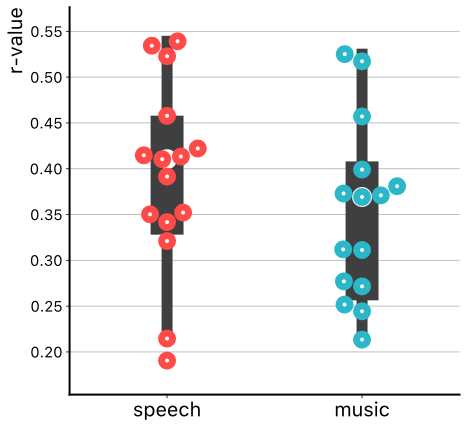

In [22]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(7, 7))
axes = ax
sns.violinplot(x="labels",
               y="data",
               inner='box',
               cut=0.3,
               data=n_df,
               linewidth=11,
               axis=axes)
sns.swarmplot(x="labels",
              y="data",
              size=7,
              linewidth=11,
              color='white',
              data=n_df,
              ax=axes)

for i, j in enumerate((0, 2)):
    axes.collections[j].set_alpha(0)

for i, j in enumerate((4, 5)):
    axes.collections[j].set_edgecolor(color[sounds[i]][1] / 255)


axes.set_xlabel('')
axes.set_xticklabels(sounds, fontsize=20)
axes.set_ylabel('r-value', fontsize=20)
plt.yticks(fontsize=15);

### TRF **absolute waveforms**

#### Prepare data (t) and collect train values

In [23]:
d = {}
seed_sujs = sujs_selection(sujs, 'implantation', 'left')
model = 'ref_bi_low_narrow_all_matlab_abs_peakrate'
temp_df = df.loc[df['chnames'].isin(all_seeds)]
for i, sound in enumerate(sounds):
    d[jn([sound, 'data'])] = []
    for j, subject in enumerate(seed_sujs):
        # prepare h5
        h5_elecs = h5Funcs('electrodes', subject)
        h5_trf = h5Funcs('trf', subject)

        # find seed index
        seed_ch = temp_df.loc[temp_df['subject']
                              == subject]['chnames'].values[0]
        chnames = correct_chnames(
            subject, h5_elecs.h5_read(keys=('chnames', )).astype('U'))
        seed_i = np.argwhere(chnames == seed_ch[:-2])[0][0]

        # get data and select only seed
        data = np.transpose(np.squeeze(h5_trf.h5_read(
            keys=('trf_final', sound, model, 'forward_train', 'w', ))))

        # take best per sound
        d[jn([sound, 'data'])].append(data[seed_i])

In [24]:
h5_trf.h5_read(keys=('trf_final', sound, model, 'forward_train', 'w', )).shape

(1, 116, 154)

In [25]:
d = {}
model = 'ref_bi_low_narrow_all_matlab_abs_peakrate'
mmodel = 'model3'
for i, sound in enumerate(sounds):
    d[jn([sound, 'data'])] = []
    for subject in sujs_selection(sujs, 'implantation', hemi):
        temp_df = df.copy()
        temp_df = temp_df.loc[(temp_df['subject'] == subject)]
        t_df = temp_df.loc[(temp_df['subject'] == subject) & (temp_df['trf_%s_%s_r' % (sound, mmodel)] == temp_df['trf_%s_%s_r' % (sound, mmodel)].max())]
        
        # prepare h5
        h5_elecs = h5Funcs('electrodes', subject)
        h5_trf = h5Funcs('trf', subject)

        # find seed index
        seed_ch = t_df['chnames'].values
        chnames = correct_chnames(
            subject, h5_elecs.h5_read(keys=('chnames', )).astype('U'))
        seed_i = np.argwhere(chnames == seed_ch[0][:-2])[0][0]

        # get data and select only seed
        data = np.transpose(np.squeeze(h5_trf.h5_read(
            keys=('trf_final', sound, model, 'forward_train', 'w', ))))

        # take best per sound
        d[jn([sound, 'data'])].append(data[seed_i])

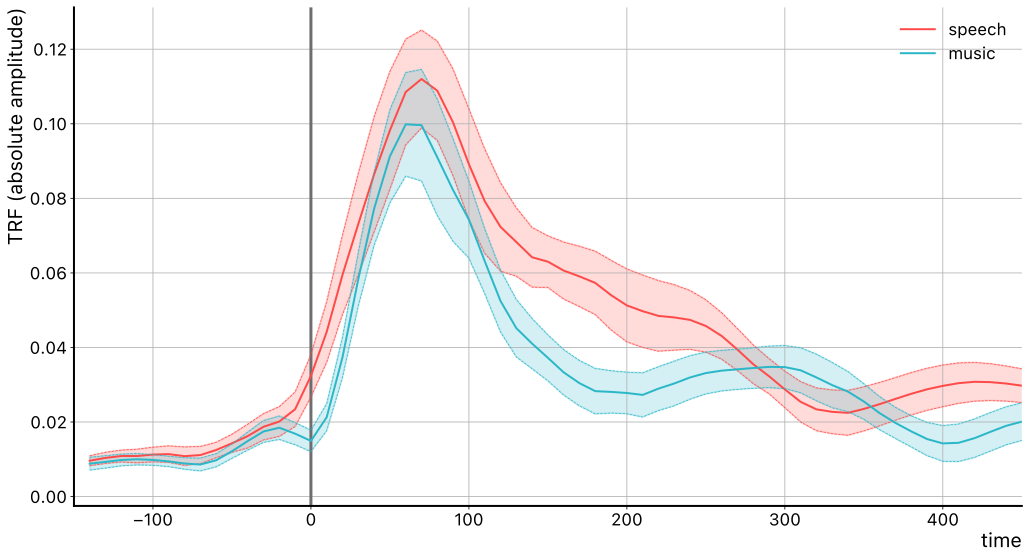

In [26]:
fig, ax = plt.subplots(figsize=(17, 9))
axes = ax
axes.axvline(0, linestyle='-', linewidth=3,
             color=color['neither_grey'][3] / 255)

t = np.linspace(-150, 1000, 116)
for sound in sounds:
    time = t[1:]
    data = np.mean(np.abs(d[jn([sound, 'data'])]), 0)[1:]
    ci = np.std(np.abs(d[jn([sound, 'data'])]), 0)[1:]
    x = np.sqrt(len(d[jn([sound, 'data'])]))
    axes.plot(time,
              data,
              alpha=1,
              linewidth=2,
              label=sound,
              color=color[sound][1] / 255)
    axes.plot(time, data - ci / x,
              color=color[sound][1] / 255, linestyle='--', linewidth=.7)
    axes.plot(time, data + ci / x,
              color=color[sound][1] / 255, linestyle='--', linewidth=.7)
    axes.fill_between(time, data - ci / x, data + ci / x,
                      alpha=.2, color=color[sound][1] / 255)
axes.legend(fancybox=True, frameon=False, fontsize=17)
axes.set_xlim([-150, 450])
axes.set_xlabel('time', fontsize=20)
axes.set_ylabel("TRF (absolute amplitude)", fontsize=20)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17);

In [27]:
d = {}
seed_sujs = sujs_selection(sujs, 'implantation', 'left')
model = 'ref_bi_low_narrow_all_matlab_abs_peakrate'
model = 'ref_bi_low_narrow_all_matlab_env'
temp_df = df.loc[df['chnames'].isin(all_seeds)]
for i, sound in enumerate(sounds):
    d[jn([sound, 'data'])] = []
    for j, subject in enumerate(seed_sujs):
        # prepare h5
        h5_elecs = h5Funcs('electrodes', subject)
        h5_trf = h5Funcs('trf', subject)

        # find seed index
        seed_ch = temp_df.loc[temp_df['subject']
                              == subject]['chnames'].values[0]
        chnames = correct_chnames(
            subject, h5_elecs.h5_read(keys=('chnames', )).astype('U'))
        seed_i = np.argwhere(chnames == seed_ch[:-2])[0][0]

        # get data and select only seed
        data = np.transpose(np.squeeze(h5_trf.h5_read(
            keys=('trf_final', sound, model, 'forward_train', 'w', ))))

        # take best per sound
        d[jn([sound, 'data'])].append(data[seed_i])

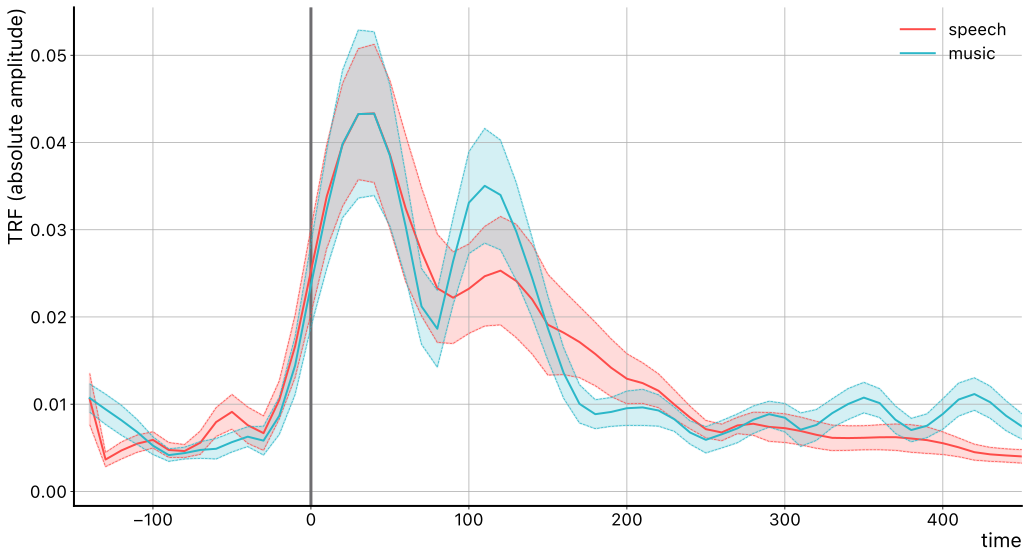

In [28]:
fig, ax = plt.subplots(figsize=(17, 9))
axes = ax
axes.axvline(0, linestyle='-', linewidth=3,
             color=color['neither_grey'][3] / 255)

t = np.linspace(-150, 1000, 116)
for sound in sounds:
    time = t[1:]
    data = np.mean(np.abs(d[jn([sound, 'data'])]), 0)[1:]
    ci = np.std(np.abs(d[jn([sound, 'data'])]), 0)[1:]
    x = np.sqrt(len(d[jn([sound, 'data'])]))
    axes.plot(time,
              data,
              alpha=1,
              linewidth=2,
              label=sound,
              color=color[sound][1] / 255)
    axes.plot(time, data - ci / x,
              color=color[sound][1] / 255, linestyle='--', linewidth=.7)
    axes.plot(time, data + ci / x,
              color=color[sound][1] / 255, linestyle='--', linewidth=.7)
    axes.fill_between(time, data - ci / x, data + ci / x,
                      alpha=.2, color=color[sound][1] / 255)
axes.legend(fancybox=True, frameon=False, fontsize=17)
axes.set_xlim([-150, 450])
axes.set_xlabel('time', fontsize=20)
axes.set_ylabel("TRF (absolute amplitude)", fontsize=20)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17);

### Inspect distributions all Models 

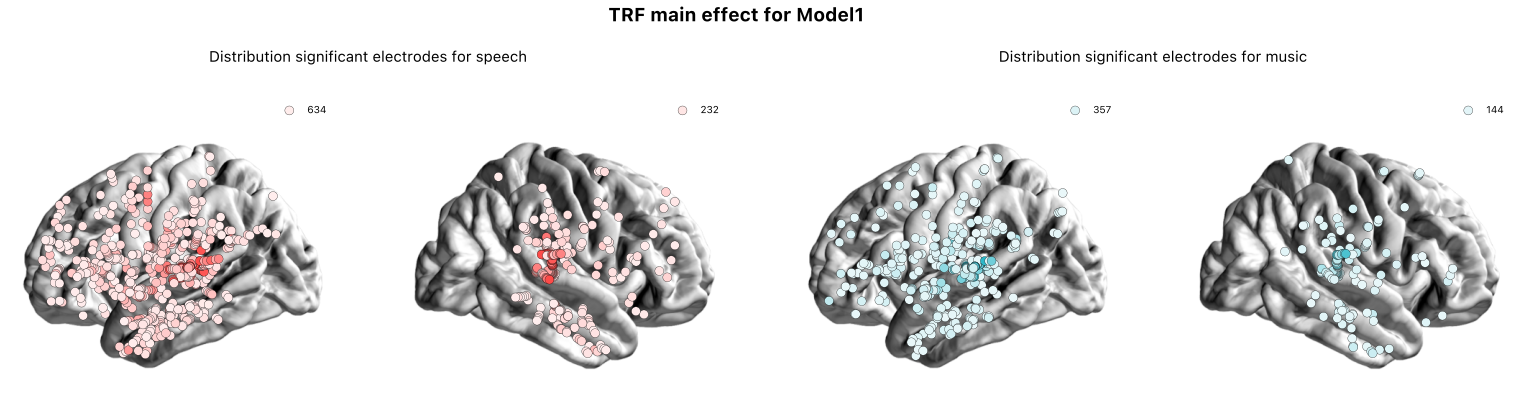

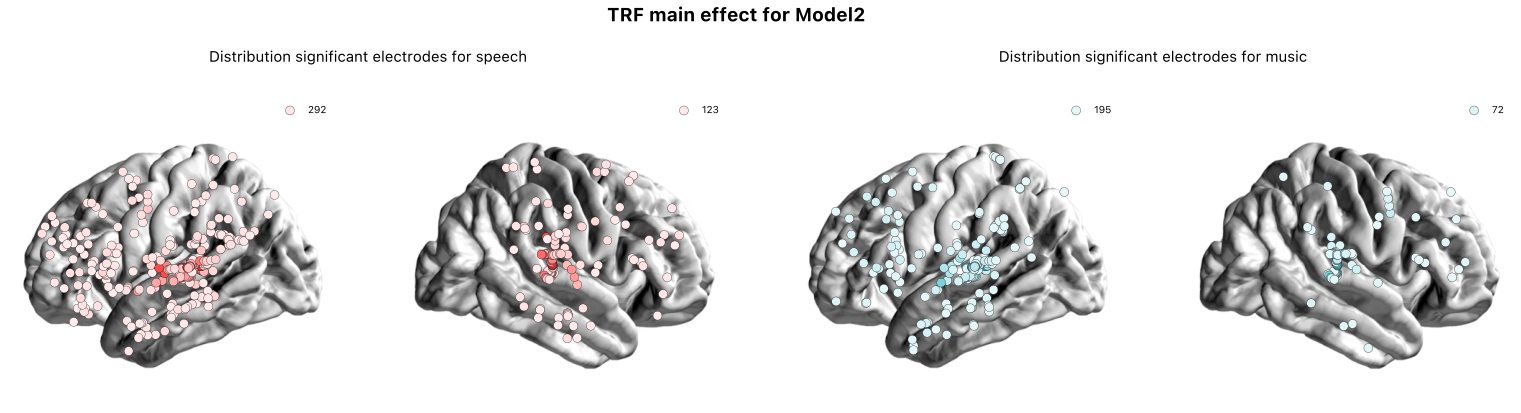

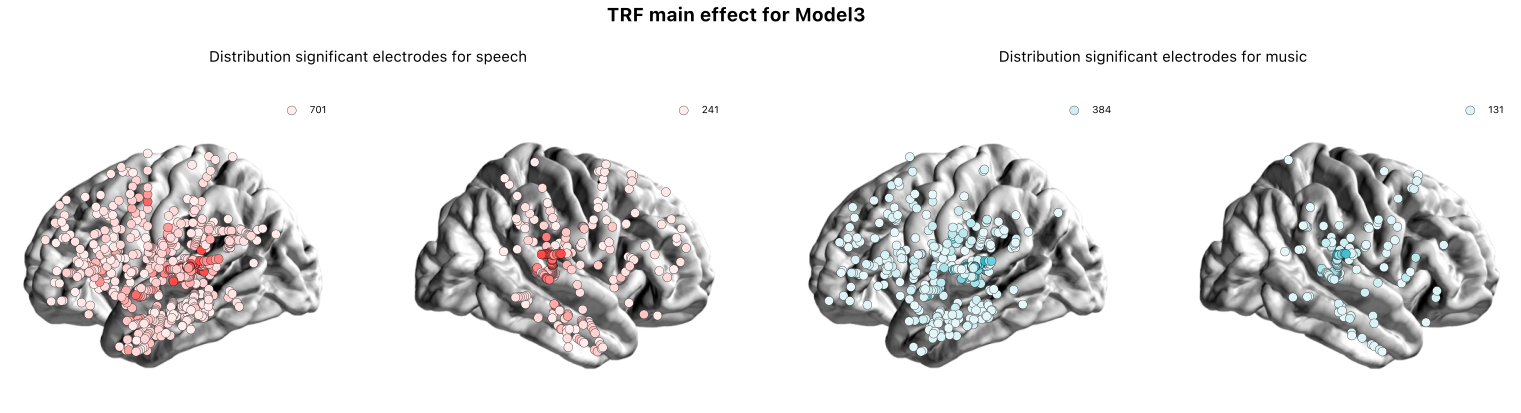

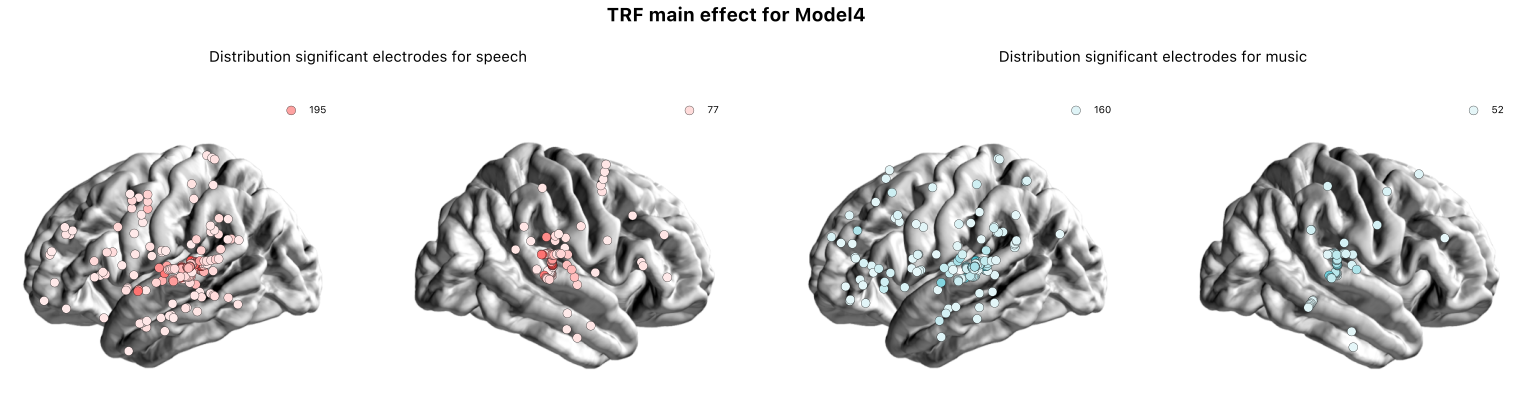

In [29]:
model = 'model3'
for model in models:

    # prepare fig
    fig, ax = plt.subplots(1, len(hemis) * 2, figsize=(27, 7))
    fig.suptitle('%s main effect for %s' %
                 (analysis.upper(), model.capitalize()), weight='bold', fontsize=19)

    c = -1
    ext = []
    edge = .1
    for i, sound in enumerate(sounds):
        cmap, norm = set_cmapnorm(['main'], 0, .3, sound, alpha=False)
        for o, orientation in enumerate(hemis):
            c += 1
            axes = ax[c]
            im = h5Funcs('electrodes', file='mayavi').h5_read(
                keys=(orientation, 'imp', ))

            temp_df = df.loc[(df['trf_main_%s_%s_new_sign' % (model, sound)] > 0)]
            values = temp_df['trf_main_%s_%s_new_sign' % (model, sound)].values
            df_x = temp_df[jn([orientation, 'x'])].values
            df_y = temp_df[jn([orientation, 'y'])].values
            _, _, left_i, right_i = split_hemis(
                chlist=temp_df['chnames'].values)
            if orientation in ['left', 'right']:
                x_h = df_x[left_i] if orientation == 'left' else df_x[right_i]
                y_h = df_y[left_i] if orientation == 'left' else df_y[right_i]
                values_h = values[left_i] if orientation == 'left' else values[right_i]
            else:
                x_h = df_x
                y_h = df_y
                values_h = values

            if len(df_x) == 0:
                continue

            axes.imshow(im)
            axes.scatter(x_h,
                         y_h,
                         c=values_h,
                         # cmap=my_cmap['main_' + sound],
                         cmap=cmap,
                         norm=norm,
                         label='%s' % (len(x_h)),
                         s=80 * np.ones(len(x_h)),
                         linewidth=0.3, 
                         edgecolors='k')

            axes.set_axis_off()
            axes.legend(fancybox=True)

            # save the axes bounding boxes for later use
            ext.append([axes.get_window_extent().x0,
                       axes.get_window_extent().width])

    # from the axes bounding boxes calculate the optimal position of the column spanning title
    inv = fig.transFigure.inverted()
    width_left = ext[0][0] + (ext[1][0] + ext[1][1] - ext[0][0]) / 2.
    left_center = inv.transform((width_left, 1))
    width_right = ext[2][0] + (ext[3][0] + ext[3][1] - ext[2][0]) / 2.
    right_center = inv.transform((width_right, 1))

    # set column spanning title
    # the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
    plt.figtext(left_center[0], 0.88, 'Distribution significant electrodes for speech',
                va="center", ha="center", size=15)
    plt.figtext(right_center[0], 0.88, 'Distribution significant electrodes for music',
                va="center", ha="center", size=15);

### Put plots in grid

In [30]:
from plotters.plot_decorators import my_fonts
fig3 = plt.figure(figsize=(27, 31), constrained_layout=False)
gs = fig3.add_gridspec(4, 4, wspace=0.05)
orientations = ('left', 'right')

fticks = 27
flabels = 35
fcount = 52
lwidth = 2

# TRF distribution
###########################################################################################
model = 'model3'
c = -1
ext = []
edge = .1
for i, sound in enumerate(sounds):
    cmap, norm = set_cmapnorm(['main'], 0, .12, sound, alpha=True)
    for o, orientation in enumerate(hemis):
        c += 1
        trf_distr = fig3.add_subplot(gs[:1, c])

        # Turn off axes and set axes limits
        axes = trf_distr
        if i == 0 and o == 0:
            axes.set_title('a'.upper(), fontsize=fcount, loc='left')
        elif i == 1 and o == 0:
            axes.set_title('b'.upper(), fontsize=fcount, loc='left')
            
        im = h5Funcs('electrodes', file='mayavi').h5_read(
            keys=(orientation, 'imp', ))

        temp_df = df.loc[(df['trf_main_%s_%s_new_sign' % (model, sound)] > 0)]
        values = temp_df['trf_main_%s_%s_new_sign' % (model, sound)].values
        df_x = temp_df[jn([orientation, 'x'])].values
        df_y = temp_df[jn([orientation, 'y'])].values
        _, _, left_i, right_i = split_hemis(
            chlist=temp_df['chnames'].values)
        if orientation in ['left', 'right']:
            x_h = df_x[left_i] if orientation == 'left' else df_x[right_i]
            y_h = df_y[left_i] if orientation == 'left' else df_y[right_i]
            values_h = values[left_i] if orientation == 'left' else values[right_i]
        else:
            x_h = df_x
            y_h = df_y
            values_h = values

        if len(df_x) == 0:
            continue

        axes.imshow(im)
        axes.scatter(x_h,
                     y_h,
                     c=values_h,
                     # cmap=my_cmap['main_' + sound],
                     cmap=cmap,
                     norm=norm,
                     # label='%s' % (len(x_h)),
                     s=80 * np.ones(len(x_h)),
                     linewidth=0.3, 
                     edgecolors='k')
        
        axes.set_axis_off()

        # save the axes bounding boxes for later use
        ext.append([axes.get_window_extent().x0,
                   axes.get_window_extent().width])


# TRF model comparison
###########################################################################################
n0 = 0
new_list = [main_model, 'other_model', 'shared']
circles = ('10', '01', '11')
for s, sound in enumerate(sounds):
    for m, model in enumerate(other_models):
        if model == 'model1':
            name = 'envelope & LF'
        elif model == 'model2':
            name = 'envelope & HFa'
        elif model == 'model3':
            name = 'peakRate & LF'
        else:
            name = 'peakRate & HFa'
        n0 += 1
        tmp = [len(trf[jn([sound, model, x, 'i'])]) for x in new_list]
        
        trf_models = fig3.add_subplot(gs[1 + s, m])
        axes = trf_models
        
        ch_nr = sum(np.array(tmp))
        tmp = np.round(tmp / np.sum(tmp) * 100, 0).astype(int)
        c = venn2(tmp, set_labels=None, alpha=.9)
        c.get_patch_by_id('10').set_color(color[sound][1] / 255)
        c.get_patch_by_id('01').set_color(color['neither_grey'][2] / 255)
        c.get_patch_by_id('11').set_color(color[sound][0] / 255)
        c.get_patch_by_id('11').set_edgecolor('white')
        c.get_patch_by_id('11').set_linewidth(13)
        # Shrink current axis's height by 10% on the bottom
        box = axes.get_position()
        axes.set_position([box.x0 + box.width * .1,
                           box.y0 - box.height * .1 if sound == 'speech' else box.y0 + box.height * .1,
                           box.height * 1.01,
                           box.width * 1.01])
        for circle in circles:
            c.get_label_by_id(circle).set_text('')
            
        # Total channel count
        plt.annotate('%s channels (%s%%)' % (ch_nr, round(ch_nr / len(df) * 100)),
                     xy=c.get_label_by_id(
                         '01').get_position() - np.array([0, 0.05]),
                     xytext=(0, 165),
                     ha='right',
                     fontsize=fticks,# + 3,
                     font=my_fonts('heavy'),
                     textcoords='offset points')
        # Model 1
        plt.annotate('%s: %s%%' % ('peakRate & LF', tmp[0]),
                     xy=c.get_label_by_id(
                         '10').get_position() - np.array([0, 0.05]),
                     xytext=(100, -125),
                     ha='center',
                     fontsize=fticks,
                     textcoords='offset points',
                     arrowprops=dict(arrowstyle='->',
                                     linewidth=lwidth,
                                     connectionstyle='arc3, rad=-0.5',
                                     color='black'))
        # Model alternative
        plt.annotate('%s: %s%%' % (name, tmp[1]),
                     xy=c.get_label_by_id(
                         '01').get_position() - np.array([0, 0.05]),
                     xytext=(0, 125),
                     ha='right',
                     fontsize=fticks,
                     textcoords='offset points',
                     arrowprops=dict(arrowstyle='->',
                                     linewidth=lwidth,
                                     connectionstyle='arc3, rad=-0.5',
                                     color='black'))

        # hand put c, this BS
        if sound == 'speech' and m == 0:
            plt.annotate('%s' % ('c'.upper()),
                         xy=c.get_label_by_id('10').get_position(),
                         xytext=(-80, 190),
                         ha='center',
                         fontsize=fcount,
                         textcoords='offset points')


# seed insets
###########################################################################################
model = 'model3'
c = -1
ext = []
for o, orientation in enumerate(('top', 'left')):
    trf_seeds = fig3.add_subplot(gs[1+o, -1])
    axes = trf_seeds
    if o == 0:
        axes.set_title('d'.upper(), fontsize=fcount, loc='left')
    else:
        box = axes.get_position()
        axes.set_position([box.x0,
                           box.y0 + box.height * .2,
                           box.width,
                           box.height])  # box.y0 - box.height * .1,, box.height * .9])
    # axes = inset_axes(trf_erp, width='30%', height=2+3*o, loc=1)
    im = h5Funcs('electrodes', file='mayavi').h5_read(
        keys=(orientation, 'imp', ))

    temp_df = df.loc[df['chnames'].isin(all_seeds)]
    df_x = temp_df[jn([orientation, 'x'])].values
    df_y = temp_df[jn([orientation, 'y'])].values
    _, _, left_i, right_i = split_hemis(
        chlist=temp_df['chnames'].values)
    if orientation in ('left', 'right'):
        x_h = df_x[left_i] if orientation == 'left' else df_x[right_i]
        y_h = df_y[left_i] if orientation == 'left' else df_y[right_i]
    else:
        x_h = df_x
        y_h = df_y

    axes.imshow(im)
    axes.scatter(x_h,
                 y_h,
                 color=color['shared'][1] / 255,
                 s=120 * np.ones(len(x_h)),
                 edgecolors='k')
    axes.set_axis_off()

    
# TRF erps
###########################################################################################
trf_erp = fig3.add_subplot(gs[-1, :1])
axes = trf_erp
axes.set_title('e'.upper(), fontsize=fcount, loc='left')
box = axes.get_position()
axes.set_position([box.x0 + box.width * .3,
                   box.y0,
                   box.height,
                   box.width * .88])
axes.axvline(0, linestyle='-', linewidth=3,
             color=color['neither_grey'][3] / 255)
for sound in sounds:
    data = np.mean(np.abs(d[jn([sound, 'data'])]), 0)[1:]
    data = np.mean(np.abs(d[jn([sound, 'data'])]), 0)[1:]
    ci = np.std(np.abs(d[jn([sound, 'data'])]), 0)[1:]
    x = np.sqrt(len(d[jn([sound, 'data'])]))
    time = t[1:]
    axes.plot(time,
              data,
              label=sound,
              color=color[sound][1] / 255)
    axes.plot(time, data - ci / x,
              color=color[sound][1] / 255, linestyle='--', linewidth=.7)
    axes.plot(time, data + ci / x,
              color=color[sound][1] / 255, linestyle='--', linewidth=.7)
    axes.fill_between(time, data - ci / x, data + ci / x,
                      alpha=.2, color=color[sound][1] / 255)
axes.set_xlim([-150, 450])
axes.set_xlabel('time', fontsize=flabels)
axes.set_ylabel("TRF (absolute amplitude)", fontsize=flabels)
plt.yticks(fontsize=fticks)
plt.xticks(fontsize=fticks)



# prepare legend
###########################################################################################
fpath = '/Library/Fonts'
font = 'Regular'
prop = fm.FontProperties(fname=pjoin(
    fpath, 'SF-Pro-Text-%s.otf' % font), size=fcount)
legend_s = fig3.add_subplot(gs[-1, -2:])
axes = legend_s
sounds_l = [mpatches.Patch(color=color[sound][1] /
                           255, label=sound) for sound in sounds]
axes.set_axis_off()
axes.legend(handles=sounds_l,
            loc='center',
            prop=prop)

# TRF r-values
###########################################################################################
trf_r = fig3.add_subplot(gs[-1, 1])
axes = trf_r
box = axes.get_position()
axes.set_position([box.x0 + box.width * .5,
                   box.y0,
                   box.height,
                   box.width * .88])  # box.y0 - box.height * .1,, box.height * .9])
axes.set_title('f'.upper(), fontsize=fcount, loc='left')
sns.violinplot(x="labels",
               y="data",
               inner='box',
               cut=0.3,
               data=n_df,
               linewidth=11,
               axis=axes)
sns.swarmplot(x="labels",
              y="data",
              size=13,
              linewidth=7,
              color='white',
              data=n_df,
              ax=axes)

for i, j in enumerate((0, 2)):
    axes.collections[j].set_alpha(0)

for i, j in enumerate((4, 5)):
    axes.collections[j].set_edgecolor(color[sounds[i]][1] / 255)

axes.set_ylim([0, 0.57])
axes.set_xlabel('')
axes.set_xticklabels(sounds, fontsize=flabels)
axes.set_ylabel('Prediction correlation', fontsize=flabels)
plt.yticks(fontsize=fticks)
plt.tight_layout()